# Fitting the longitudinal shower profile

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import hgc_testbeam as hgc
import math
import scipy
from scipy.optimize import curve_fit

In [2]:
def grindhammer(t, alpha, beta, E):
    return E * ((beta*t)**(alpha-1)*beta*np.exp(-beta*t)) / scipy.special.gamma(alpha)

In [3]:
def longitudinal_profile(df, normalize=False):
    x0_max = df.query("rechit_layer == 28").rechit_X0.values[0]
    df = df.groupby(["event", "rechit_X0"]).sum()
    df = df.reset_index()
    df = df.groupby("rechit_X0").median()
    if normalize:
        df["rechit_energy"] = df["rechit_energy"] / df["rechit_energy"].sum()
    else:
        df["rechit_energy"] = df["rechit_energy"]
    df = df.reset_index()
    df = df[df.rechit_X0 <= x0_max]
    
    return df.rechit_X0, df.rechit_energy

In [4]:
electron_runlist = hgc.runlist.query('Particle == "electron"')
electron_runlist = electron_runlist.query('Configuration == "22b"') 
electron_runlist = hgc.runlist.query("Particle == 'electron'").groupby("Energy").apply(lambda x : x.iloc[1])
#electron_runlist = electron_runlist.reset_index()
energy = electron_runlist.Energy.values

Loading rechitntupler/hits from run 437... Done.


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Loading rechitntupler/hits from run 595... Done.
Loading rechitntupler/hits from run 457... Done.
Loading rechitntupler/hits from run 467... Done.
Loading rechitntupler/hits from run 479... Done.
Loading rechitntupler/hits from run 621... Done.
Loading rechitntupler/hits from run 494... Done.
Loading rechitntupler/hits from run 665... Done.
Loading rechitntupler/hits from run 385... Done.
Loading rechitntupler/hits from run 406... Done.


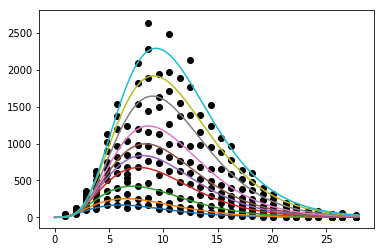

In [5]:
data = dict(
    beam_energy=[],
    cog=[],
    #cog_std=[],
    alpha=[],
    alpha_std=[],
    beta=[],
    beta_std=[],
    E=[],
    E_std=[],
)
plt.figure(figsize=(8,8))
for run in electron_runlist.Run:
    df = hgc.load_run(run, columns = ["beamEnergy","event", "rechit_layer", "rechit_X0", "rechit_energy"], verbosity=1)
    df["rechit_X0_times_energy"] = df.rechit_energy * df.rechit_X0
    gb = df.groupby("event")
    cogs = gb["rechit_X0_times_energy"].sum() / gb["rechit_energy"].sum()
    
    data["beam_energy"].append(df["beamEnergy"].values[0])
    #data["cog"].append(cogs.mean())
    #data["cog_std"].append(cogs.std())
    
    x0, energy = longitudinal_profile(df)
    plt.scatter(x0, energy, color='k')
    
    data["cog"].append(np.sum(x0 * energy)/np.sum(energy))
    
    popt, pcov = curve_fit(grindhammer, x0, energy, maxfev=2000)
    
    xx = np.linspace(0, 28, 200)
    plt.plot(xx, grindhammer(xx, *popt))
    
    data["alpha"].append(popt[0])
    data["beta"].append(popt[1])
    data["E"].append(popt[2])
    data["alpha_std"].append(pcov[0,0]**0.5)
    data["beta_std"].append(pcov[1,1]**0.5)
    data["E_std"].append(pcov[2,2]**0.5)

profile_df = pd.DataFrame(data=data)
plt.show()

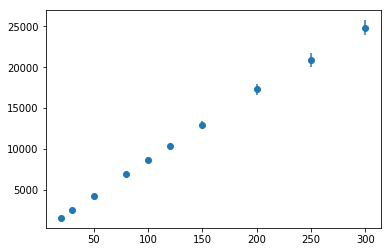

In [6]:
plt.errorbar(profile_df.beam_energy, profile_df.E, yerr=profile_df.E_std, fmt='o')
plt.show()

<ErrorbarContainer object of 3 artists>

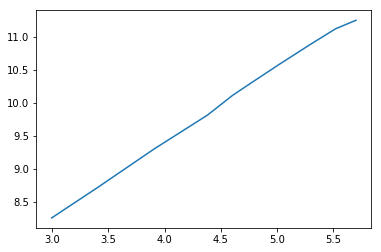

In [7]:
plt.errorbar(np.log(profile_df.beam_energy), (profile_df.alpha/profile_df.beta))

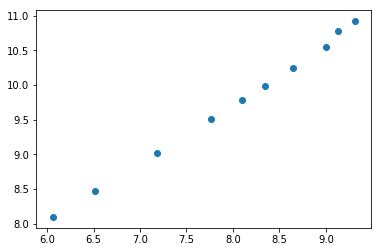

In [8]:
plt.scatter((profile_df.alpha -1)/profile_df.beta, profile_df.cog)

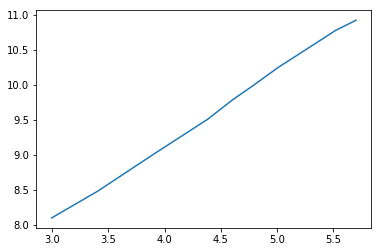

In [9]:
plt.plot(np.log(profile_df.beam_energy), profile_df.cog)